# Analyzing Change in Gender Equality Worldwide
#### Team 3B (Yulong Gong, Peter Mankiewich, Ruchika Venkateswaran, Yi-shuan Wang, Yangyang Zhou)

---




* Link to Tableau presentation (includes dashboards and story)
https://public.tableau.com/profile/yi.shuan.wang#!/vizhome/Team3B/Team3BPresentation_Story?publish=yes

## Project Objective
Our goal is to analyze the fluctuations in gender equality in different countries between 2000 to 2015 across education and employment indicators in high, upper middle, lower middle and low income segment groups. 

The health indicators do not provide detailed gender level insights and therefore do not add value to our project objective. For the purpose of this project, we will only be looking at employment, education and life expectancy indicators. Additionally, we will only be looking at data between 2000 to 2015 since a significant number of indicators were missing for countries in the earlier years.

## Dataset Overview
The World Development Indicators dataset has been taken from Kaggle at *https://www.kaggle.com/worldbank/world-development-indicators*, while the raw dataset from World Bank can be found at *https://datacatalog.worldbank.org/dataset/world-development-indicators*.

The dataset contains over 5.6 million rows with over 1340 annual indicators of economic development from over 200 countries around the world dated between 1960 to 2015. The indicators span across five key categories: Education, Employment, Life Expectancy, Economic and Health indicators.

##### There are two tables stored under the **"Indicator"** dataset.
1.  **Country** contains the information about all the countries and regions, such as the country code, the county name, the region a country belongs to, and the income group a country belongs to.
2.   **Indicator** includes the names of all the development indicators, their corresponding values collected in each country or region, and the year each value was collected.


In [2]:
# Run this to connect to BigQuery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
%%bigquery --project ba775-team-3b
SELECT COUNT(*) AS number_of_rows
FROM `ba775-team-3b.Indicator.Indicator`;

,number_of_rows
0,5656458


##### **Is there any null value in the CountryCode column?**
> There is no missing value in the CountryCode column in both tables, so CountryCode can serve as a key when joining tables.

In [4]:
%%bigquery --project ba775-team-3b
SELECT COUNT(CountryCode) AS number_of_null
FROM `ba775-team-3b.Indicator.Country`
WHERE CountryCode IS NULL;

,number_of_null
0,0


In [5]:
%%bigquery --project ba775-team-3b
SELECT COUNT(CountryCode) AS number_of_null
FROM `ba775-team-3b.Indicator.Indicator`
WHERE CountryCode IS NULL;

,number_of_null
0,0


## Inspecting The Data

---



### Inspecting the Country Table

**How many regions are in the dataset?**
> The world is divided into 7 regions in the dataset.


In [6]:
%%bigquery --project ba775-team-3b
SELECT distinct(Region) 
FROM `ba775-team-3b.Indicator.Country`
WHERE Region IS NOT NULL;

,Region
0,South Asia
1,East Asia & Pacific
2,Sub-Saharan Africa
3,Latin America & Caribbean
4,Europe & Central Asia
5,Middle East & North Africa
6,North America


**How many countries are in the dataset?**


> There are 214 countries worldwide.


In [7]:
%%bigquery --project ba775-team-3b
SELECT COUNT(CountryCode) AS number_of_countries
FROM `ba775-team-3b.Indicator.Country`
WHERE CountryCode IS NOT NULL AND Region IS NOT NULL;

,number_of_countries
0,214


**How many income groups are there? And which countries belong to which income group?**
> There are 5 income groups -- high (OECD), high (non-OECD), upper middle, lower middle and low. The countries in each income group are listed below.

In [8]:
%%bigquery --project ba775-team-3b
SELECT IncomeGroup, 
    COUNT(CountryCode) AS number_of_countries,
    STRING_AGG(DISTINCT ShortName, " - " ORDER BY ShortName) AS Countries,
    STRING_AGG(DISTINCT CountryCode, " - " ORDER BY CountryCode) AS CountryCodes
FROM `ba775-team-3b.Indicator.Country`
WHERE IncomeGroup IS NOT NULL
GROUP BY IncomeGroup;

,IncomeGroup,number_of_countries,Countries,CountryCodes
0,Low income,31,Afghanistan - Benin - Burkina Faso - Burundi -...,AFG - BDI - BEN - BFA - CAF - COM - ERI - ETH ...
1,Lower middle income,51,Armenia - Bangladesh - Bhutan - Bolivia - Cabo...,ARM - BGD - BOL - BTN - CIV - CMR - COG - CPV ...
2,Upper middle income,53,Albania - Algeria - American Samoa - Angola - ...,AGO - ALB - ASM - AZE - BGR - BIH - BLR - BLZ ...
3,High income: nonOECD,47,Andorra - Antigua and Barbuda - Argentina - Ar...,ABW - ADO - ARE - ARG - ATG - BHR - BHS - BMU ...
4,High income: OECD,32,Australia - Austria - Belgium - Canada - Chile...,AUS - AUT - BEL - CAN - CHE - CHL - CZE - DEU ...


> We put the two high income groups together and created a new table **"IncomeGroup4"** with countries assigned to 4 income groups -- **"Low income", "Lower middle income", "Upper middle income", and "High income".**

In [9]:
%%bigquery --project ba775-team-3b
CREATE OR REPLACE TABLE `ba775-team-3b.Indicator.IncomeGroup4`AS
SELECT
    CountryCode,
    Shortname,
        CASE WHEN IncomeGroup LIKE 'Low income%' THEN 'Low income'
         WHEN IncomeGroup LIKE 'Lower middle%' THEN 'Lower middle income'
         WHEN IncomeGroup LIKE 'Upper middle%' THEN 'Upper middle income'
         WHEN IncomeGroup LIKE 'High income%' THEN 'High income'
         END AS IncomeGroup,
FROM `ba775-team-3b.Indicator.Country`
WHERE IncomeGroup IS NOT NULL;

""


In [10]:
%%bigquery --project ba775-team-3b
SELECT IncomeGroup, 
    COUNT(CountryCode) AS number_of_countries,
    STRING_AGG(DISTINCT ShortName, " - " ORDER BY ShortName) AS Countries,
    STRING_AGG(DISTINCT CountryCode, " - " ORDER BY CountryCode) AS CountryCodes
FROM `ba775-team-3b.Indicator.IncomeGroup4`
GROUP BY IncomeGroup
ORDER BY number_of_countries;

,IncomeGroup,number_of_countries,Countries,CountryCodes
0,Low income,31,Afghanistan - Benin - Burkina Faso - Burundi -...,AFG - BDI - BEN - BFA - CAF - COM - ERI - ETH ...
1,Lower middle income,51,Armenia - Bangladesh - Bhutan - Bolivia - Cabo...,ARM - BGD - BOL - BTN - CIV - CMR - COG - CPV ...
2,Upper middle income,53,Albania - Algeria - American Samoa - Angola - ...,AGO - ALB - ASM - AZE - BGR - BIH - BLR - BLZ ...
3,High income,79,Andorra - Antigua and Barbuda - Argentina - Ar...,ABW - ADO - ARE - ARG - ATG - AUS - AUT - BEL ...


### Inspecting the Indicator Table

**How many indicators are there in the dataset?**
> There are 1344 unique indicators in total and we created a new table **"Indicator_Name"** to store them.

In [11]:
%%bigquery --project ba775-team-3b
CREATE OR REPLACE TABLE `ba775-team-3b.Indicator.Indicator_Name`AS
SELECT distinct(IndicatorName)
FROM `ba775-team-3b.Indicator.Indicator`
ORDER BY IndicatorName;

""


In [12]:
%%bigquery --project ba775-team-3b
SELECT * FROM `ba775-team-3b.Indicator.Indicator_Name`;

,IndicatorName
0,"2005 PPP conversion factor, GDP (LCU per inter..."
1,"2005 PPP conversion factor, private consumptio..."
2,ARI treatment (% of children under 5 taken to ...
3,Access to electricity (% of population)
4,"Access to electricity, rural (% of rural popul..."
...,...
1339,Women's share of population ages 15+ living wi...
1340,"Youth literacy rate, population 15-24 years, b..."
1341,"Youth literacy rate, population 15-24 years, f..."
1342,"Youth literacy rate, population 15-24 years, g..."


**How many values availabe for each year in the dataset?**
> Even though there are over 1340 indicators and more than 200 countries, there were less than 100000 values available every year before 1990. Therefore, in order to have a better understanding of the trend worldwide, we decided to only use data collected after 2000 so that there are more values avaiable for each year.

In [13]:
%%bigquery --project ba775-team-3b
SELECT Year, count(*) num_of_data
FROM `ba775-team-3b.Indicator.Indicator` 
WHERE CountryCode in (SELECT CountryCode FROM `ba775-team-3b.Indicator.IncomeGroup4`)
GROUP BY Year
ORDER BY Year
LIMIT 10;

,Year,num_of_data
0,1960,19696
1,1961,22582
2,1962,24175
3,1963,24395
4,1964,24849
5,1965,27452
6,1966,26889
7,1967,28089
8,1968,27897
9,1969,28244


**How many countries have value for each indicator?**
> For example, in 2000, among all 1344 inidcators, 1135 of them have values for at least one country.

In [14]:
%%bigquery --project ba775-team-3b
SELECT IndicatorName, count(*) AS num_of_countries
FROM `ba775-team-3b.Indicator.Indicator`
WHERE Year=2000 AND CountryCode in (SELECT CountryCode FROM `ba775-team-3b.Indicator.IncomeGroup4`)
GROUP BY IndicatorName
ORDER BY num_of_countries DESC

,IndicatorName,num_of_countries
0,Adjusted savings: mineral depletion (current US$),214
1,"Population, total",214
2,Population growth (annual %),214
3,Population density (people per sq. km of land ...,213
4,Surface area (sq. km),213
...,...,...
1130,Quasi money (current LCU),1
1131,"Share of youth not in education, employment, o...",1
1132,"Children in employment, wage workers, male (% ...",1
1133,"Children in employment, wage workers, female (...",1


**How much data do we have for each country? And which countries do we have the most data for?**

> For example, in 2000, we have data for all 214 countries and we have the most data for Mexico, Peru, and Romania.

In [15]:
%%bigquery --project ba775-team-3b
SELECT CountryName, count(IndicatorName) as num_of_indicators
FROM `ba775-team-3b.Indicator.Indicator`
WHERE Year=2000 AND CountryCode in (select CountryCode from `ba775-team-3b.Indicator.IncomeGroup4`)
GROUP BY CountryName
ORDER BY num_of_indicators DESC
LIMIT 15;

,CountryName,num_of_indicators
0,Mexico,978
1,Peru,978
2,Romania,953
3,India,946
4,Bolivia,934
5,Moldova,934
6,Panama,927
7,Bulgaria,926
8,Colombia,918
9,Jordan,909


**How many gender-related indicators are there in the dataset?**


> There are 76 indicators related to male and 91 indicators related to female.




In [16]:
%%bigquery --project ba775-team-3b
SELECT IndicatorName 
FROM `ba775-team-3b.Indicator.Indicator_Name`
WHERE IndicatorName LIKE "%Male%" OR IndicatorName LIKE "% male%"

,IndicatorName
0,"Adjusted net enrolment rate, primary, male (%)"
1,"Adult literacy rate, population 15+ years, mal..."
2,"Average working hours of children, study and w..."
3,"Average working hours of children, working onl..."
4,"Child employment in agriculture, male (% of ma..."
...,...
71,"Unemployment, youth male (% of male labor forc..."
72,"Unemployment, youth male (% of male labor forc..."
73,"Vulnerable employment, male (% of male employm..."
74,"Wage and salary workers, male (% of males empl..."


In [17]:
%%bigquery --project ba775-team-3b
SELECT IndicatorName 
FROM `ba775-team-3b.Indicator.Indicator_Name`
WHERE IndicatorName LIKE "%Female%" OR IndicatorName LIKE "%female%"

,IndicatorName
0,"Adjusted net enrolment rate, primary, female (%)"
1,"Adult literacy rate, population 15+ years, fem..."
2,"Average working hours of children, study and w..."
3,"Average working hours of children, working onl..."
4,"Child employment in agriculture, female (% of ..."
...,...
86,"Unemployment, youth female (% of female labor ..."
87,"Unemployment, youth female (% of female labor ..."
88,"Vulnerable employment, female (% of female emp..."
89,"Wage and salaried workers, female (% of female..."


Finally, we created another table **"All"** with all the countries, income groups, indicators, values and years. Below is a preview of this table.

In [18]:
%%bigquery --project ba775-team-3b
CREATE OR REPLACE TABLE `ba775-team-3b.Indicator.All` AS
SELECT A.CountryCode, A.CountryName, B.IncomeGroup, A.IndicatorName, A.Value, A.Year
FROM `ba775-team-3b.Indicator.Indicator` A
LEFT JOIN `ba775-team-3b.Indicator.IncomeGroup4` B
USING (CountryCode)

""


In [19]:
%%bigquery --project ba775-team-3b
SELECT *
FROM `ba775-team-3b.Indicator.All`
LIMIT 3;

,CountryCode,CountryName,IncomeGroup,IndicatorName,Value,Year
0,SLB,Solomon Islands,Lower middle income,"Population, ages 15-64 (% of total)",5.473958e+01,1960
1,EAS,East Asia & Pacific (all income levels),None,"Net bilateral aid flows from DAC donors, Canad...",3.160000e+06,1961
2,NOC,High income: nonOECD,None,"Survival to age 65, male (% of cohort)",5.742761e+01,1961


# Exploratory Data Analysis

---




## Economic Indicators

**What is the GNI per capita (current US$) for each country in 2014?**
> Countries are classified as members of each income group based on the estimate of their GNI per capita. Countries with higher GNI per capita are labeled as members of the high income group, and countries with lower GNI per capita are labeled as members of the low income group.

In [20]:
%%bigquery --project ba775-team-3b
SELECT A.CountryName, A.Year, A.GNI, B.Population, GNI/Population AS GNI_per_capita
FROM
(
  SELECT CountryName, CountryCode,Value AS GNI, Year
  FROM `ba775-team-3b.Indicator.Indicator`
  WHERE IndicatorName = 'GNI (current US$)'
  AND Year BETWEEN 2000 AND 2015
) A
INNER JOIN
(
  SELECT CountryName, CountryCode,Value AS Population, Year
  FROM `ba775-team-3b.Indicator.Indicator`
  WHERE IndicatorName = 'Population, total'
  AND Year BETWEEN 2000 AND 2015
) B
USING(CountryCode, Year)
INNER JOIN `ba775-team-3b.Indicator.IncomeGroup4`
USING (CountryCode)
WHERE A.Year=2014
ORDER BY GNI_per_capita DESC
LIMIT 20;

,CountryName,Year,GNI,Population,GNI_per_capita
0,Norway,2014,5.111475e+11,5136475.0,99513.279869
1,Qatar,2014,2.008085e+11,2172065.0,92450.509761
2,"Macao SAR, China",2014,4.770634e+10,577914.0,82549.205624
3,Luxembourg,2014,4.320376e+10,556074.0,77694.259290
4,Denmark,2014,3.522237e+11,5639565.0,62455.834804
5,Sweden,2014,5.909070e+11,9689555.0,60983.916929
6,Australia,2014,1.415798e+12,23490736.0,60270.492123
7,United States,2014,1.781270e+13,318857056.0,55864.217726
8,Singapore,2014,2.985792e+11,5469700.0,54587.856115
9,Netherlands,2014,8.904055e+11,16854183.0,52829.941898


## Education Indicators

**What is the average adult literacy rate for females in each income group between 2000 and 2015?**
> The female literacy rate is on average higher in countries with higher income throughout the years.

In [21]:
%%bigquery --project ba775-team-3b
SELECT IncomeGroup, Year, avg(Value) as female_literacy_rate
FROM
(
SELECT G.IncomeGroup, I.IndicatorName as name, I.Value, I.year as year
FROM `ba775-team-3b.Indicator.Indicator` as I
INNER JOIN `ba775-team-3b.Indicator.IncomeGroup4` as G
ON G.CountryCode = I.CountryCode
)
WHERE (name = 'Adult literacy rate, population 15+ years, female (%)') AND (year Between 2000 and 2015)
GROUP BY IncomeGroup, Year
ORDER BY Year, female_literacy_rate
LIMIT 10;

,IncomeGroup,Year,female_literacy_rate
0,Low income,2000,42.202451
1,Lower middle income,2000,72.554465
2,Upper middle income,2000,88.075679
3,High income,2000,89.350086
4,Low income,2001,32.782338
5,Lower middle income,2001,71.133203
6,Upper middle income,2001,84.668086
7,High income,2001,94.083309
8,Low income,2002,46.151690
9,Lower middle income,2002,65.644260


**What is the difference in the average adult literacy rate between males and females in each income group between 2000 and 2015?**
> A positive number means male litercay rate is higher than female literacy rate.

In [22]:
%%bigquery --project ba775-team-3b
SELECT M.IncomeGroup, M.Year, avg(M.male_literacy) male_literacy, avg(F.female_literacy) female_literacy, avg(M.male_literacy) - avg(F.female_literacy) AS difference
FROM
(
    SELECT CountryCode, IncomeGroup, Year, avg(Value) as male_literacy
    FROM `ba775-team-3b.Indicator.All`
    WHERE IndicatorName = 'Adult literacy rate, population 15+ years, male (%)' AND year Between 2000 and 2015 AND IncomeGroup IS NOT NULL
    GROUP BY CountryCode, IncomeGroup, Year
) M
INNER JOIN
(
    SELECT CountryCode, IncomeGroup, Year, avg(Value) as female_literacy
    FROM `ba775-team-3b.Indicator.All`
    WHERE IndicatorName = 'Adult literacy rate, population 15+ years, female (%)' AND year Between 2000 and 2015 AND IncomeGroup IS NOT NULL
    GROUP BY CountryCode, IncomeGroup, Year

) F
USING(CountryCode)
GROUP BY M.IncomeGroup, M.Year
ORDER BY Year, female_literacy
LIMIT 10;

,IncomeGroup,Year,male_literacy,female_literacy,difference
0,Low income,2000,63.414988,46.440971,16.974018
1,Lower middle income,2000,82.100386,73.571183,8.529203
2,Upper middle income,2000,91.568796,90.497287,1.071509
3,High income,2000,95.494153,91.827888,3.666265
4,Low income,2001,53.388236,35.028922,18.359314
5,Lower middle income,2001,81.046939,75.597683,5.449256
6,Upper middle income,2001,92.934954,86.638152,6.296802
7,High income,2001,96.236532,95.216311,1.020221
8,Low income,2002,70.204311,53.591171,16.613140
9,Lower middle income,2002,74.396918,61.557539,12.839379


**How does the adult literacy rate change over time for countries in the low income group?**
> Take Uganda for example. We can tell that the adult literacy rate is increasing in Uganda over the years.

In [23]:
%%bigquery --project ba775-team-3b
SELECT CountryName, Year, Value
FROM `ba775-team-3b.Indicator.Indicator`
WHERE IndicatorName = 'Adult literacy rate, population 15+ years, both sexes (%)' and CountryName = 'Uganda'
ORDER BY year

,CountryName,Year,Value
0,Uganda,1991,56.107380
1,Uganda,2002,68.142509
2,Uganda,2006,71.373146
3,Uganda,2010,73.211884
4,Uganda,2012,70.198219


**What is the difference in the average enrollment rate for primary education between males and females in each income group between 2000 and 2015?**
> If the difference is negative, it means the enrollment rate for primary education is higher for females than for males.

In [24]:
%%bigquery --project ba775-team-3b
SELECT M.IncomeGroup, M.Year, avg(M.male_enrolment) male_enrolment, avg(F.female_enrolment) female_enrolment, avg(M.male_enrolment) - avg(F.female_enrolment) AS difference
FROM
(
    SELECT CountryCode, IncomeGroup, Year, avg(Value) as male_enrolment
    FROM `ba775-team-3b.Indicator.All`
    WHERE IndicatorName = 'Adjusted net enrolment rate, primary, male (%)' AND year Between 2000 and 2015 AND IncomeGroup IS NOT NULL
    GROUP BY CountryCode, IncomeGroup, Year
) M
INNER JOIN
(
    SELECT CountryCode, IncomeGroup, Year, avg(Value) as female_enrolment
    FROM `ba775-team-3b.Indicator.All`
    WHERE IndicatorName = 'Adjusted net enrolment rate, primary, female (%)' AND year Between 2000 and 2015 AND IncomeGroup IS NOT NULL
    GROUP BY CountryCode, IncomeGroup, Year

) F
USING(CountryCode)
GROUP BY M.IncomeGroup, M.Year
ORDER BY Year, female_enrolment
LIMIT 10;

,IncomeGroup,Year,male_enrolment,female_enrolment,difference
0,Low income,2000,57.835536,64.799836,-6.964300
1,Lower middle income,2000,77.835684,82.371824,-4.536139
2,Upper middle income,2000,93.431460,93.773004,-0.341544
3,High income,2000,96.629391,96.756486,-0.127096
4,Low income,2001,59.374853,63.245127,-3.870275
5,Lower middle income,2001,81.126568,84.327844,-3.201276
6,Upper middle income,2001,93.982505,94.200198,-0.217694
7,High income,2001,96.571678,96.627323,-0.055644
8,Low income,2002,60.798775,63.118349,-2.319575
9,Lower middle income,2002,83.207598,84.478311,-1.270713


**What is the average government expenditure on primary education as a percent of GDP, in each country income group between 2000 and 2015?**
> The government expenditure on primary education as a percentage of GDP is higher in countries with higher income.

In [25]:
%%bigquery --project ba775-team-3b
SELECT IncomeGroup, Year, avg(Value) as value
FROM
(
SELECT G.IncomeGroup, I.IndicatorName as name, I.Value, I.year as year
FROM `ba775-team-3b.Indicator.Indicator` as I
INNER JOIN `ba775-team-3b.Indicator.IncomeGroup4` as G
ON G.CountryCode = I.CountryCode
)
WHERE name = 'Government expenditure per primary student as % of GDP per capita (%)' AND year Between 2000 and 2015
GROUP BY IncomeGroup, Year
ORDER BY Year, value
LIMIT 10;

,IncomeGroup,Year,value
0,Low income,2000,10.222706
1,Lower middle income,2000,13.900634
2,Upper middle income,2000,14.108141
3,High income,2000,15.865744
4,Low income,2001,10.227810
5,Upper middle income,2001,13.993856
6,Lower middle income,2001,14.738268
7,High income,2001,16.818815
8,Low income,2002,9.392389
9,Lower middle income,2002,11.576116


**How does the government expenditure on education change over time?**
> Take Australia, a high income country, for example. We can tell the education expenditure as a percentage of GDP increased over the years.

In [26]:
%%bigquery --project ba775-team-3b
SELECT year, Value
FROM `ba775-team-3b.Indicator.Indicator`
WHERE IndicatorName = 'Government expenditure on education as % of GDP (%)' and CountryName = 'Denmark'
ORDER BY year

,year,Value
0,1970,6.02943
1,1971,6.48275
2,1972,6.55638
3,1973,6.32187
4,1974,6.63196
5,1975,6.75038
6,1977,5.68559
7,1978,5.76126
8,1979,5.59097
9,1980,5.93262


## Employment Indicators

**How many labor force indicators are there in the dataset?**
> There are 22 indicators related to labor force.

In [27]:
%%bigquery --project ba775-team-3b
SELECT  IndicatorName FROM `ba775-team-3b.Indicator.Indicator_Name`
WHERE IndicatorName LIKE "%labor force%"

,IndicatorName
0,Armed forces personnel (% of total labor force)
1,"Labor force with primary education, female (% ..."
2,"Labor force with primary education, male (% of..."
3,"Labor force with secondary education, female (..."
4,"Labor force with secondary education, male (% ..."
5,"Labor force with tertiary education, female (%..."
6,"Labor force with tertiary education, male (% o..."
7,"Labor force, female (% of total labor force)"
8,Ratio of female to male labor force participat...
9,Ratio of female to male labor force participat...


**What is the total labor force in each country in 2014?**
> The countries that have the most labor force in 2014 are China, India and United States.

In [28]:
%%bigquery --project ba775-team-3b
SELECT  CountryName, Value AS labor_force, Year
FROM `ba775-team-3b.Indicator.All`
WHERE IndicatorName LIKE "%Labor force, total%" AND Year=2014 AND IncomeGroup IS NOT NULL
ORDER BY labor_force DESC, CountryName
LIMIT 10;

,CountryName,labor_force,Year
0,China,806498521.0,2014
1,India,496960163.0,2014
2,United States,161048950.0,2014
3,Indonesia,124061112.0,2014
4,Brazil,109842906.0,2014
5,Bangladesh,78976778.0,2014
6,Russian Federation,76754167.0,2014
7,Pakistan,65361409.0,2014
8,Japan,65302348.0,2014
9,Nigeria,55784248.0,2014


**What is the proportion of male and female labor in 2014?**
> In 2014, Rwanda had the highest ratio of female labor, and 7 out of the top 10 countries belong to the low income group. United Arab Emirates had the lowest ratio of female labor, and the 10 countries with the lowest ratio are located in the Middle East.

In [29]:
%%bigquery --project ba775-team-3b
SELECT  CountryName, IncomeGroup, year, 100-Value AS male_labor, Value AS female_labor ,
FROM `ba775-team-3b.Indicator.All`
WHERE IndicatorName LIKE "%Labor force, female (% of total labor force)%" AND IncomeGroup IS NOT NULL AND Year=2014
ORDER BY female_labor DESC
LIMIT 10;

,CountryName,IncomeGroup,year,male_labor,female_labor
0,Rwanda,Low income,2014,46.049326,53.950674
1,Mozambique,Low income,2014,46.872261,53.127739
2,Burundi,Low income,2014,48.511468,51.488532
3,Malawi,Low income,2014,48.634217,51.365783
4,Togo,Low income,2014,49.072705,50.927295
5,Nepal,Low income,2014,49.148314,50.851686
6,Tanzania,Low income,2014,49.866184,50.133816
7,Lithuania,High income,2014,49.911694,50.088306
8,Lao PDR,Lower middle income,2014,50.052420,49.947580
9,Latvia,High income,2014,50.057209,49.942791


In [30]:
%%bigquery --project ba775-team-3b
SELECT  CountryName, IncomeGroup, year, 100-Value AS male_labor, Value AS female_labor ,
FROM `ba775-team-3b.Indicator.All`
WHERE IndicatorName LIKE "%Labor force, female (% of total labor force)%" AND IncomeGroup IS NOT NULL AND Year=2014
ORDER BY female_labor
LIMIT 10;

,CountryName,IncomeGroup,year,male_labor,female_labor
0,United Arab Emirates,High income,2014,86.883236,13.116764
1,Oman,High income,2014,86.588703,13.411297
2,Qatar,High income,2014,86.474942,13.525058
3,Saudi Arabia,High income,2014,84.768086,15.231914
4,Syrian Arab Republic,Lower middle income,2014,84.489377,15.510623
5,Afghanistan,Low income,2014,83.948561,16.051439
6,Algeria,Upper middle income,2014,82.623844,17.376156
7,Iraq,Upper middle income,2014,82.323094,17.676906
8,"Iran, Islamic Rep.",Upper middle income,2014,81.664845,18.335155
9,Jordan,Upper middle income,2014,81.626807,18.373193


**How does the employment to population ratio differ between males and females in each income group between 2000 and 2015?**
> The employment to population ratio is higher for males than for females, and their difference is the largest in upper middle income group.

In [31]:
%%bigquery --project ba775-team-3b
SELECT M.IncomeGroup, M.Year, avg(M.male_employment) male_employment, avg(F.female_employment) female_employment, avg(M.male_employment) - avg(F.female_employment) AS difference
FROM
(
    SELECT CountryCode, IncomeGroup, Year, avg(Value) as male_employment
    FROM `ba775-team-3b.Indicator.All`
    WHERE IndicatorName = 'Employment to population ratio, ages 15-24, male (%) (national estimate)' AND year Between 2000 and 2015 AND IncomeGroup IS NOT NULL
    GROUP BY CountryCode, IncomeGroup, Year
) M
INNER JOIN
(
    SELECT CountryCode, IncomeGroup, Year, avg(Value) as female_employment
    FROM `ba775-team-3b.Indicator.All`
    WHERE IndicatorName = 'Employment to population ratio, ages 15-24, female (%) (national estimate)' AND year Between 2000 and 2015 AND IncomeGroup IS NOT NULL
    GROUP BY CountryCode, IncomeGroup, Year

) F
USING(CountryCode)
GROUP BY M.IncomeGroup, M.Year
ORDER BY Year, female_employment
LIMIT 10;

,IncomeGroup,Year,male_employment,female_employment,difference
0,Lower middle income,2000,33.000000,18.721429,14.278571
1,Upper middle income,2000,41.994521,20.227397,21.767123
2,High income,2000,44.727128,37.220213,7.506915
3,Lower middle income,2001,29.200001,18.721429,10.478572
4,Upper middle income,2001,39.642574,21.650495,17.992079
5,High income,2001,44.352128,37.220213,7.131915
6,Lower middle income,2002,27.200001,18.721429,8.478572
7,Upper middle income,2002,37.529906,22.002804,15.527103
8,High income,2002,43.088737,36.741297,6.347440
9,Lower middle income,2003,21.799999,18.721429,3.078571


**How does the children in employment ratio differ between males and females in each income group between 2000 and 2015?**
> The children in employment ratio is the highest in coutries with lower income. If the difference is positive, it means male children in employment ratio is higher than female.

In [32]:
%%bigquery --project ba775-team-3b
SELECT M.IncomeGroup, M.Year, avg(M.male_child_employment) male_child_employment, avg(F.female_child_employment) female_child_employment, 
avg(M.male_child_employment) - avg(F.female_child_employment) AS difference
FROM
(
    SELECT CountryCode, IncomeGroup, Year, avg(Value) as male_child_employment
    FROM `ba775-team-3b.Indicator.All`
    WHERE IndicatorName = 'Children in employment, male (% of male children ages 7-14)' AND year Between 2000 and 2015 AND IncomeGroup IS NOT NULL
    GROUP BY CountryCode, IncomeGroup, Year
) M
INNER JOIN
(
    SELECT CountryCode, IncomeGroup, Year, avg(Value) as female_child_employment
    FROM `ba775-team-3b.Indicator.All`
    WHERE IndicatorName = 'Children in employment, female (% of female children ages 7-14)' AND year Between 2000 and 2015 AND IncomeGroup IS NOT NULL
    GROUP BY CountryCode, IncomeGroup, Year

) F
USING(CountryCode)
GROUP BY M.IncomeGroup, M.Year
ORDER BY male_child_employment DESC, female_child_employment DESC
LIMIT 10;

,IncomeGroup,Year,male_child_employment,female_child_employment,difference
0,Low income,2004,51.355556,37.788889,13.566667
1,Low income,2005,50.388889,37.824913,12.563976
2,Low income,2013,49.340000,42.330000,7.010000
3,Low income,2003,49.000000,43.433333,5.566667
4,Low income,2000,48.874011,38.774929,10.099083
5,Low income,2006,46.938808,39.135369,7.803439
6,Low income,2001,42.917950,32.216860,10.701089
7,Low income,2009,42.542857,42.228571,0.314286
8,Low income,2008,38.386667,38.598077,-0.211410
9,Low income,2010,35.385714,37.978849,-2.593135


**What is the unemployment with tertiary education rate for males and females in each income group between 2000 and 2015?**
> The unemployment with tertiary education rate is higher for females than for males across all income groups.

In [33]:
%%bigquery --project ba775-team-3b
SELECT M.IncomeGroup, M.Year, avg(M.male_unemployment) male_unemployment, avg(F.female_unemployment) female_unemployment
FROM
(
    SELECT CountryCode, IncomeGroup, Year, avg(Value) as male_unemployment
    FROM `ba775-team-3b.Indicator.All`
    WHERE IndicatorName = 'Unemployment with tertiary education, male (% of male unemployment)' AND year Between 2000 and 2015 AND IncomeGroup IS NOT NULL
    GROUP BY CountryCode, IncomeGroup, Year
) M
INNER JOIN
(
    SELECT CountryCode, IncomeGroup, Year, avg(Value) as female_unemployment
    FROM `ba775-team-3b.Indicator.All`
    WHERE IndicatorName = 'Unemployment with tertiary education, female (% of female unemployment)' AND year Between 2000 and 2015 AND IncomeGroup IS NOT NULL
    GROUP BY CountryCode, IncomeGroup, Year

) F
USING(CountryCode)
GROUP BY M.IncomeGroup, M.Year
ORDER BY Year, IncomeGroup
LIMIT 10;

,IncomeGroup,Year,male_unemployment,female_unemployment
0,High income,2000,11.671597,20.157143
1,Low income,2000,3.050000,8.850000
2,Lower middle income,2000,17.695834,32.730833
3,Upper middle income,2000,14.952809,22.711236
4,High income,2001,12.784824,19.923163
5,Lower middle income,2001,17.351755,33.680702
6,Upper middle income,2001,13.056872,22.327962
7,High income,2002,12.946845,20.061987
8,Lower middle income,2002,18.063114,32.313934
9,Upper middle income,2002,13.703153,21.467568


**How does the employment to population ratio differ between males and females in each income group between 2000 and 2015?**
> Male employment to population ratio is higher than female across all income groups, and the difference tends to be the largest in lower middle income groups.

In [34]:
%%bigquery --project ba775-team-3b
SELECT M.IncomeGroup, M.Year, avg(M.male_employment) male_employment, avg(F.female_employment) female_employment,
avg(M.male_employment) - avg(F.female_employment) AS difference
FROM
(
    SELECT CountryCode, IncomeGroup, Year, avg(Value) as male_employment
    FROM `ba775-team-3b.Indicator.All`
    WHERE IndicatorName LIKE 'Employment to population ratio, 15+, male (%)%' AND year Between 2000 and 2015 AND IncomeGroup IS NOT NULL
    GROUP BY CountryCode, IncomeGroup, Year
) M
INNER JOIN
(
    SELECT CountryCode, IncomeGroup, Year, avg(Value) as female_employment
    FROM `ba775-team-3b.Indicator.All`
    WHERE IndicatorName LIKE 'Employment to population ratio, 15+, female (%)%' AND year Between 2000 and 2015 AND IncomeGroup IS NOT NULL
    GROUP BY CountryCode, IncomeGroup, Year

) F
USING(CountryCode)
GROUP BY M.IncomeGroup, M.Year
ORDER BY Year, difference
LIMIT 10;

,IncomeGroup,Year,male_employment,female_employment,difference
0,Low income,2000,76.790000,63.401667,13.388333
1,High income,2000,66.767399,47.453741,19.313658
2,Upper middle income,2000,64.932463,39.268284,25.664179
3,Lower middle income,2000,70.694654,43.601431,27.093223
4,Low income,2001,76.891667,63.401667,13.490000
5,High income,2001,66.938994,47.517101,19.421894
6,Upper middle income,2001,65.071180,39.113540,25.957640
7,Lower middle income,2001,69.872180,43.500827,26.371353
8,Low income,2002,76.513333,63.401667,13.111667
9,High income,2002,66.609588,47.446059,19.163529


**How does the employment to population ratio (aged 15-24) differ between males and females in each income group between 2000 and 2015?**
> Male employment to population ratio (aged 15-24) is higher than female across all income groups, and the difference tends to be the largest in lower middle income groups too.

In [35]:
%%bigquery --project ba775-team-3b
SELECT M.IncomeGroup, M.Year, avg(M.male_employment) male_employment, avg(F.female_employment) female_employment,
avg(M.male_employment) - avg(F.female_employment) AS difference
FROM
(
    SELECT CountryCode, IncomeGroup, Year, avg(Value) as male_employment
    FROM `ba775-team-3b.Indicator.All`
    WHERE IndicatorName LIKE 'Employment to population ratio, ages 15-24, male (%)%' AND year Between 2000 and 2015 AND IncomeGroup IS NOT NULL
    GROUP BY CountryCode, IncomeGroup, Year
) M
INNER JOIN
(
    SELECT CountryCode, IncomeGroup, Year, avg(Value) as female_employment
    FROM `ba775-team-3b.Indicator.All`
    WHERE IndicatorName LIKE 'Employment to population ratio, ages 15-24, female (%)%' AND year Between 2000 and 2015 AND IncomeGroup IS NOT NULL
    GROUP BY CountryCode, IncomeGroup, Year

) F
USING(CountryCode)
GROUP BY M.IncomeGroup, M.Year
ORDER BY Year, difference
LIMIT 10;

,IncomeGroup,Year,male_employment,female_employment,difference
0,Low income,2000,57.573333,51.963556,5.609778
1,High income,2000,45.571429,34.959405,10.612024
2,Upper middle income,2000,41.979546,24.569621,17.409924
3,Lower middle income,2000,49.753409,29.966742,19.786667
4,Low income,2001,57.860000,51.963556,5.896444
5,High income,2001,44.835714,34.959405,9.876309
6,Upper middle income,2001,41.752644,24.569260,17.183384
7,Lower middle income,2001,48.950000,29.966742,18.983258
8,Low income,2002,58.096667,51.963556,6.133111
9,High income,2002,43.862014,34.925088,8.936926


**How did the female labor force with tertiary education ratio change between 2008 and 2009 in each country?**

> The female labor force with tertiary education ratio changed the most in Salvador and Sri Lanka.

In [36]:
%%bigquery --project ba775-team-3b
WITH firstyear as (
  SELECT IG.ShortName as nameF_1, IG.IncomeGroup as incomeF_1, I.IndicatorName as indicatorF_1, I.Value as valueF_1, I.Year as yearF_1
  FROM `ba775-team-3b.Indicator.IncomeGroup4`IG
  LEFT JOIN `ba775-team-3b.Indicator.Indicator`I
  ON IG.CountryCode = I.CountryCode
  WHERE I.IndicatorName = "Labor force with tertiary education, female (% of female labor force)" AND Year = 2008
), secondyear as (
   SELECT IG.ShortName as nameF_2, IG.IncomeGroup as incomeF_2, I.IndicatorName as indicatorF_2, I.Value as valueF_2, I.Year as yearF_2
  FROM `ba775-team-3b.Indicator.IncomeGroup4`IG
  LEFT JOIN `ba775-team-3b.Indicator.Indicator`I
  ON IG.CountryCode = I.CountryCode
  WHERE I.IndicatorName = "Labor force with tertiary education, female (% of female labor force)" AND Year = 2009
)
SELECT A.incomeF_1 as IncomeGroup, A.nameF_1 as CountryName, (A.valueF_1 - B.valueF_2) as Difference
FROM firstyear as A
LEFT JOIN secondyear as B
ON A.nameF_1 = B.nameF_2
ORDER BY Difference DESC
LIMIT 10

,IncomeGroup,CountryName,Difference
0,Lower middle income,El Salvador,21.600000
1,Lower middle income,Sri Lanka,17.500000
2,High income,Venezuela,8.200001
3,Upper middle income,Panama,8.000002
4,High income,"Hong Kong SAR, China",4.600000
5,Upper middle income,Colombia,2.400000
6,High income,Uruguay,2.199999
7,Lower middle income,Indonesia,1.300000
8,Upper middle income,Jordan,1.100002
9,High income,Cyprus,0.900002


**How did the male labor force with tertiary education ratio change between 2013 and 2014 in each country?**
> There are a number of higher income countries with a large increase in this period, such as Austria, Luxembourg and Norway.

In [37]:
%%bigquery --project ba775-team-3b
WITH firstyear as (
  SELECT IG.ShortName as nameF_1, IG.IncomeGroup as incomeF_1, I.IndicatorName as indicatorF_1, I.Value as valueF_1, I.Year as yearF_1
  FROM `ba775-team-3b.Indicator.IncomeGroup4`IG
  LEFT JOIN `ba775-team-3b.Indicator.Indicator`I
  ON IG.CountryCode = I.CountryCode
  WHERE I.IndicatorName = "Labor force with tertiary education, male (% of male labor force)" AND Year = 2014
), secondyear as (
   SELECT IG.ShortName as nameF_2, IG.IncomeGroup as incomeF_2, I.IndicatorName as indicatorF_2, I.Value as valueF_2, I.Year as yearF_2
  FROM `ba775-team-3b.Indicator.IncomeGroup4`IG
  LEFT JOIN `ba775-team-3b.Indicator.Indicator`I
  ON IG.CountryCode = I.CountryCode
  WHERE I.IndicatorName = "Labor force with tertiary education, male (% of male labor force)" AND Year = 2013
)
SELECT A.incomeF_1 as IncomeGroup, A.nameF_1 as CountryName, (A.valueF_1 - B.valueF_2) as Difference
FROM firstyear as A
LEFT JOIN secondyear as B
ON A.nameF_1 = B.nameF_2
ORDER BY Difference DESC
LIMIT 10;

,IncomeGroup,CountryName,Difference
0,High income,Austria,9.799999
1,High income,Luxembourg,5.400002
2,High income,Norway,3.899998
3,High income,Portugal,2.200000
4,High income,Lithuania,2.100000
5,Upper middle income,Malaysia,1.400002
6,High income,Sweden,1.400002
7,High income,Belgium,1.299999
8,High income,Croatia,1.200001
9,High income,Finland,1.199997


## Life Expectancy Indicators

**An overview of the life expectancy over time for all countries**

In [38]:
%%bigquery --project ba775-team-3b
SELECT CountryName, Year, IndicatorName, Value
FROM  `ba775-team-3b.Indicator.Indicator` 
WHERE (IndicatorName = 'Life expectancy at birth, female (years)' or IndicatorName = 'Life expectancy at birth, male (years)') AND Year BETWEEN 2000 AND 2015
ORDER BY Year, CountryName, IndicatorName
LIMIT 10;

,CountryName,Year,IndicatorName,Value
0,Afghanistan,2000,"Life expectancy at birth, female (years)",56.265
1,Afghanistan,2000,"Life expectancy at birth, male (years)",54.041
2,Albania,2000,"Life expectancy at birth, female (years)",77.419
3,Albania,2000,"Life expectancy at birth, male (years)",71.275
4,Algeria,2000,"Life expectancy at birth, female (years)",71.973
5,Algeria,2000,"Life expectancy at birth, male (years)",68.480
6,Angola,2000,"Life expectancy at birth, female (years)",46.621
7,Angola,2000,"Life expectancy at birth, male (years)",43.856
8,Antigua and Barbuda,2000,"Life expectancy at birth, female (years)",75.947
9,Antigua and Barbuda,2000,"Life expectancy at birth, male (years)",70.969


**What is the average male life expectancy at birth across each income group between 2000 and 2015?**
> The male life expectancy at birth is higher in countries with higher income.

In [39]:
%%bigquery --project ba775-team-3b
SELECT IncomeGroup, IndicatorName, avg(Value) as average_life_expectancy
FROM
(
SELECT G.IncomeGroup, I.IndicatorName, I.Value, I.year as year
FROM `ba775-team-3b.Indicator.Indicator` as I
INNER JOIN `ba775-team-3b.Indicator.IncomeGroup4` as G
ON G.CountryCode = I.CountryCode
)
WHERE IndicatorName = 'Life expectancy at birth, male (years)' AND year Between 2000 and 2015
GROUP BY IncomeGroup, IndicatorName
ORDER BY average_life_expectancy

,IncomeGroup,IndicatorName,average_life_expectancy
0,Low income,"Life expectancy at birth, male (years)",54.215954
1,Lower middle income,"Life expectancy at birth, male (years)",62.706196
2,Upper middle income,"Life expectancy at birth, male (years)",68.139802
3,High income,"Life expectancy at birth, male (years)",74.282156


**What is the average female life expectancy at birth across each income group between 2000 and 2015?**
> The female life expectancy at birth is higher in countries with higher income. Life expctancy for females is also higher than for males in all income groups.

In [40]:
%%bigquery --project ba775-team-3b
SELECT IncomeGroup, IndicatorName, avg(Value) as average_life_expectancy
FROM
(
SELECT G.IncomeGroup, I.IndicatorName, I.Value, I.year as year
FROM `ba775-team-3b.Indicator.Indicator` as I
INNER JOIN `ba775-team-3b.Indicator.IncomeGroup4` as G
ON G.CountryCode = I.CountryCode
)
WHERE IndicatorName = 'Life expectancy at birth, female (years)' AND year Between 2000 and 2015
GROUP BY IncomeGroup, IndicatorName
ORDER BY average_life_expectancy

,IncomeGroup,IndicatorName,average_life_expectancy
0,Low income,"Life expectancy at birth, female (years)",56.903403
1,Lower middle income,"Life expectancy at birth, female (years)",66.868954
2,Upper middle income,"Life expectancy at birth, female (years)",73.493990
3,High income,"Life expectancy at birth, female (years)",80.002992


**Examine the life expectancy for a low income country between 2000 and 2015.**
> For example, upon observing the life expectancy in Zimbabwe, we noticed its value increasing over the years.



In [41]:
%%bigquery --project ba775-team-3b
SELECT year, Value
FROM `ba775-team-3b.Indicator.Indicator`
WHERE IndicatorName = "Life expectancy at birth, total (years)" AND year Between 2000 and 2015 AND CountryName = 'Zimbabwe'
ORDER BY year

,year,Value
0,2000,41.689439
1,2001,40.996805
2,2002,40.679146
3,2003,40.702488
4,2004,41.059341
5,2005,41.759610
6,2006,42.810707
7,2007,44.177756
8,2008,45.804488
9,2009,47.624659


**Examine the life expectancy for a high income country between 2000 and 2015.**
> For example, upon observing the life expectancy in Switzerland, we noticed its value increasing over the years too, but not as much as Zimbabwe.



In [42]:
%%bigquery --project ba775-team-3b
SELECT year, Value
FROM `ba775-team-3b.Indicator.Indicator`
WHERE IndicatorName = "Life expectancy at birth, total (years)" AND year Between 2000 and 2015 AND CountryName = 'Switzerland'
ORDER BY year

,year,Value
0,2000,79.680488
1,2001,80.180488
2,2002,80.385366
3,2003,80.536585
4,2004,81.087805
5,2005,81.236585
6,2006,81.490244
7,2007,81.741463
8,2008,81.992683
9,2009,82.043902


**An overview of the infant mortality rate (per 1000 newborns) over time for all countries**

In [43]:
%%bigquery --project ba775-team-3b
SELECT CountryName, Year, IndicatorName, Value
FROM  `ba775-team-3b.Indicator.Indicator` 
WHERE IndicatorName = 'Mortality rate, infant (per 1,000 live births)' AND Year BETWEEN 2000 AND 2015
ORDER BY Year, CountryName, IndicatorName
LIMIT 10;

,CountryName,Year,IndicatorName,Value
0,Afghanistan,2000,"Mortality rate, infant (per 1,000 live births)",95.400000
1,Albania,2000,"Mortality rate, infant (per 1,000 live births)",23.200000
2,Algeria,2000,"Mortality rate, infant (per 1,000 live births)",33.900000
3,Andorra,2000,"Mortality rate, infant (per 1,000 live births)",3.900000
4,Angola,2000,"Mortality rate, infant (per 1,000 live births)",128.300000
5,Antigua and Barbuda,2000,"Mortality rate, infant (per 1,000 live births)",13.800000
6,Arab World,2000,"Mortality rate, infant (per 1,000 live births)",44.100931
7,Argentina,2000,"Mortality rate, infant (per 1,000 live births)",18.000000
8,Armenia,2000,"Mortality rate, infant (per 1,000 live births)",26.600000
9,Australia,2000,"Mortality rate, infant (per 1,000 live births)",5.100000


**What is the average infant mortality rate (per 1,000 newborns) across each income group between 2000 and 2015?**
> The infant mortality is higher in countries with lower income. The rate is 10 times higher in the low income group as compared to that of the high income group.



In [44]:
%%bigquery --project ba775-team-3b
SELECT IncomeGroup, IndicatorName, avg(Value) as average_mortality_rate
FROM
(
SELECT G.IncomeGroup, I.IndicatorName, I.Value, I.year as year
FROM `ba775-team-3b.Indicator.Indicator` as I
INNER JOIN `ba775-team-3b.Indicator.IncomeGroup4` as G
ON G.CountryCode = I.CountryCode
)
WHERE IndicatorName = 'Mortality rate, infant (per 1,000 live births)' AND year Between 2000 and 2015
GROUP BY IncomeGroup, IndicatorName
ORDER BY average_mortality_rate

,IncomeGroup,IndicatorName,average_mortality_rate
0,High income,"Mortality rate, infant (per 1,000 live births)",7.965572
1,Upper middle income,"Mortality rate, infant (per 1,000 live births)",22.462139
2,Lower middle income,"Mortality rate, infant (per 1,000 live births)",42.536500
3,Low income,"Mortality rate, infant (per 1,000 live births)",71.107258




**Examine the infant mortality rate for a low income country between 2000 and 2015.**
> For example, upon observing the infant mortality rate in Zimbabwe, we noticed its value decreasing over the years.


In [45]:
%%bigquery --project ba775-team-3b
SELECT year, Value
FROM `ba775-team-3b.Indicator.Indicator`
WHERE IndicatorName = 'Mortality rate, infant (per 1,000 live births)' and CountryName = 'Zimbabwe' and year between 2000 and 2015
ORDER BY year

,year,Value
0,2000,63.5
1,2001,63.2
2,2002,62.7
3,2003,61.9
4,2004,61.5
5,2005,61.0
6,2006,60.3
7,2007,59.9
8,2008,58.9
9,2009,57.7




**Examine the infant mortality rate for a high income country between 2000 and 2015.**
> For example, upon observing the infant mortality rate in Switzerland, we noticed its value decreasing over the years too, but not as much as Zimbabwe.


In [46]:
%%bigquery --project ba775-team-3b
SELECT year, Value
FROM `ba775-team-3b.Indicator.Indicator`
WHERE IndicatorName = 'Mortality rate, infant (per 1,000 live births)' and CountryName = 'Switzerland' and year between 2000 and 2015
ORDER BY year

,year,Value
0,2000,4.6
1,2001,4.7
2,2002,4.6
3,2003,4.4
4,2004,4.4
5,2005,4.3
6,2006,4.2
7,2007,4.1
8,2008,4.0
9,2009,3.9


**How much has the infant mortality rate (per 1,000 newborns) decreased from 2000 to 2015 in each country?**
> The highest decrease in infant mortality rate from 2000 to 2015 is in Rwanda.


In [47]:
%%bigquery --project ba775-team-3b
SELECT C.IncomeGroup, A.CountryName, A.Value infant_mortality_2000, B.Value infant_mortality_2015, (B.Value - A.Value) as Difference
FROM
(SELECT CountryCode, CountryName, Value
FROM `ba775-team-3b.Indicator.Indicator`
WHERE IndicatorName = 'Mortality rate, infant (per 1,000 live births)' and year =2000) A
INNER JOIN
(SELECT CountryCode, CountryName, Value
FROM `ba775-team-3b.Indicator.Indicator`
WHERE IndicatorName = 'Mortality rate, infant (per 1,000 live births)' and year =2015) B
ON A.CountryName = B.CountryName
INNER JOIN
(SELECT IncomeGroup, CountryCode
FROM `ba775-team-3b.Indicator.IncomeGroup4`) C
ON A.CountryCode = C.CountryCode
ORDER BY Difference
LIMIT 10;

,IncomeGroup,CountryName,infant_mortality_2000,infant_mortality_2015,Difference
0,Low income,Rwanda,109.2,31.1,-78.1
1,Low income,Liberia,123.0,52.8,-70.2
2,Low income,Malawi,103.5,43.4,-60.1
3,Low income,Mozambique,115.0,56.7,-58.3
4,Low income,Sierra Leone,143.3,87.1,-56.2
5,Low income,Cambodia,80.4,24.6,-55.8
6,Lower middle income,Zambia,97.6,43.3,-54.3
7,Low income,Uganda,90.0,37.7,-52.3
8,Low income,South Sudan,109.5,60.3,-49.2
9,Low income,Ethiopia,89.5,41.4,-48.1


> We also note that there is a marginal change in infant mortality rate in high income countries.

In [48]:
%%bigquery --project ba775-team-3b
SELECT C.IncomeGroup, A.CountryName, A.Value infant_mortality_2000, B.Value infant_mortality_2015, (B.Value - A.Value) as difference
FROM
(SELECT CountryCode, CountryName, Value
FROM `ba775-team-3b.Indicator.Indicator`
WHERE IndicatorName = 'Mortality rate, infant (per 1,000 live births)' and year =2000) A
INNER JOIN
(SELECT CountryCode, CountryName, Value
FROM `ba775-team-3b.Indicator.Indicator`
WHERE IndicatorName = 'Mortality rate, infant (per 1,000 live births)' and year =2015) B
ON A.CountryName = B.CountryName
INNER JOIN
(SELECT IncomeGroup, CountryCode
FROM `ba775-team-3b.Indicator.IncomeGroup4`) C
ON A.CountryCode = C.CountryCode
ORDER BY difference DESC
LIMIT 10;

,IncomeGroup,CountryName,infant_mortality_2000,infant_mortality_2015,difference
0,Upper middle income,Dominica,13.4,19.6,6.2
1,High income,Brunei Darussalam,7.6,8.6,1.0
2,High income,Seychelles,12.3,11.7,-0.6
3,Lower middle income,Vanuatu,23.8,23.1,-0.7
4,Upper middle income,Tonga,15.1,14.4,-0.7
5,High income,France,4.4,3.5,-0.9
6,High income,Canada,5.2,4.3,-0.9
7,High income,Sweden,3.4,2.4,-1.0
8,High income,Singapore,3.1,2.1,-1.0
9,High income,Switzerland,4.6,3.4,-1.2


# Findings


---




## GNI per Capita
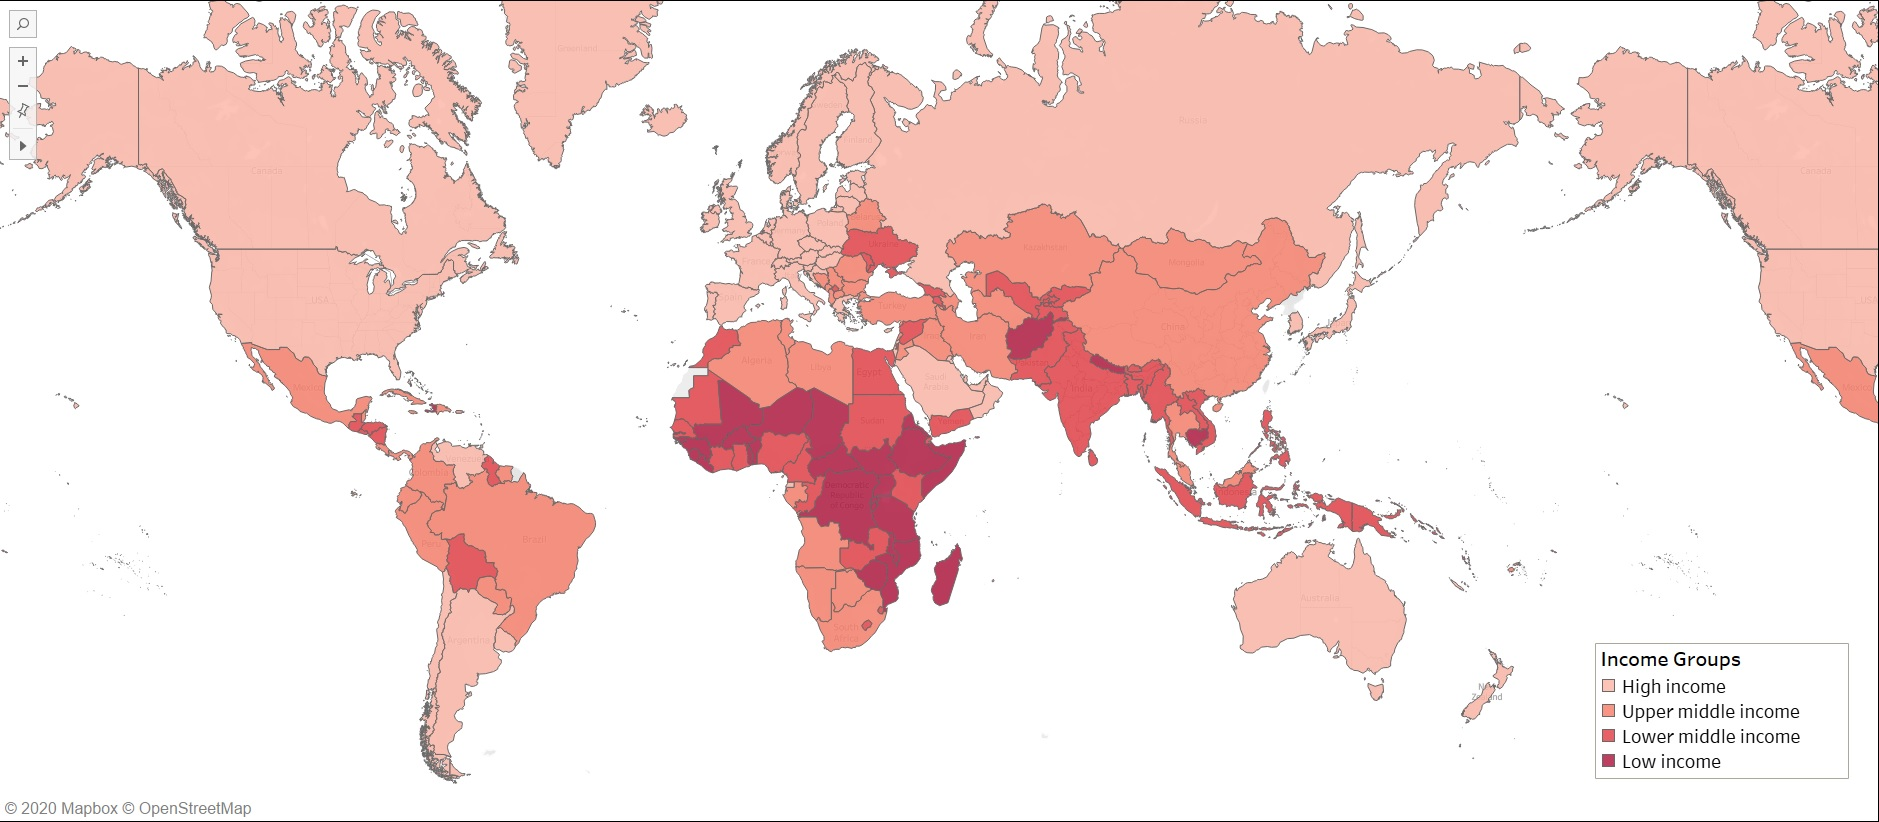

## Analytical Report on Education

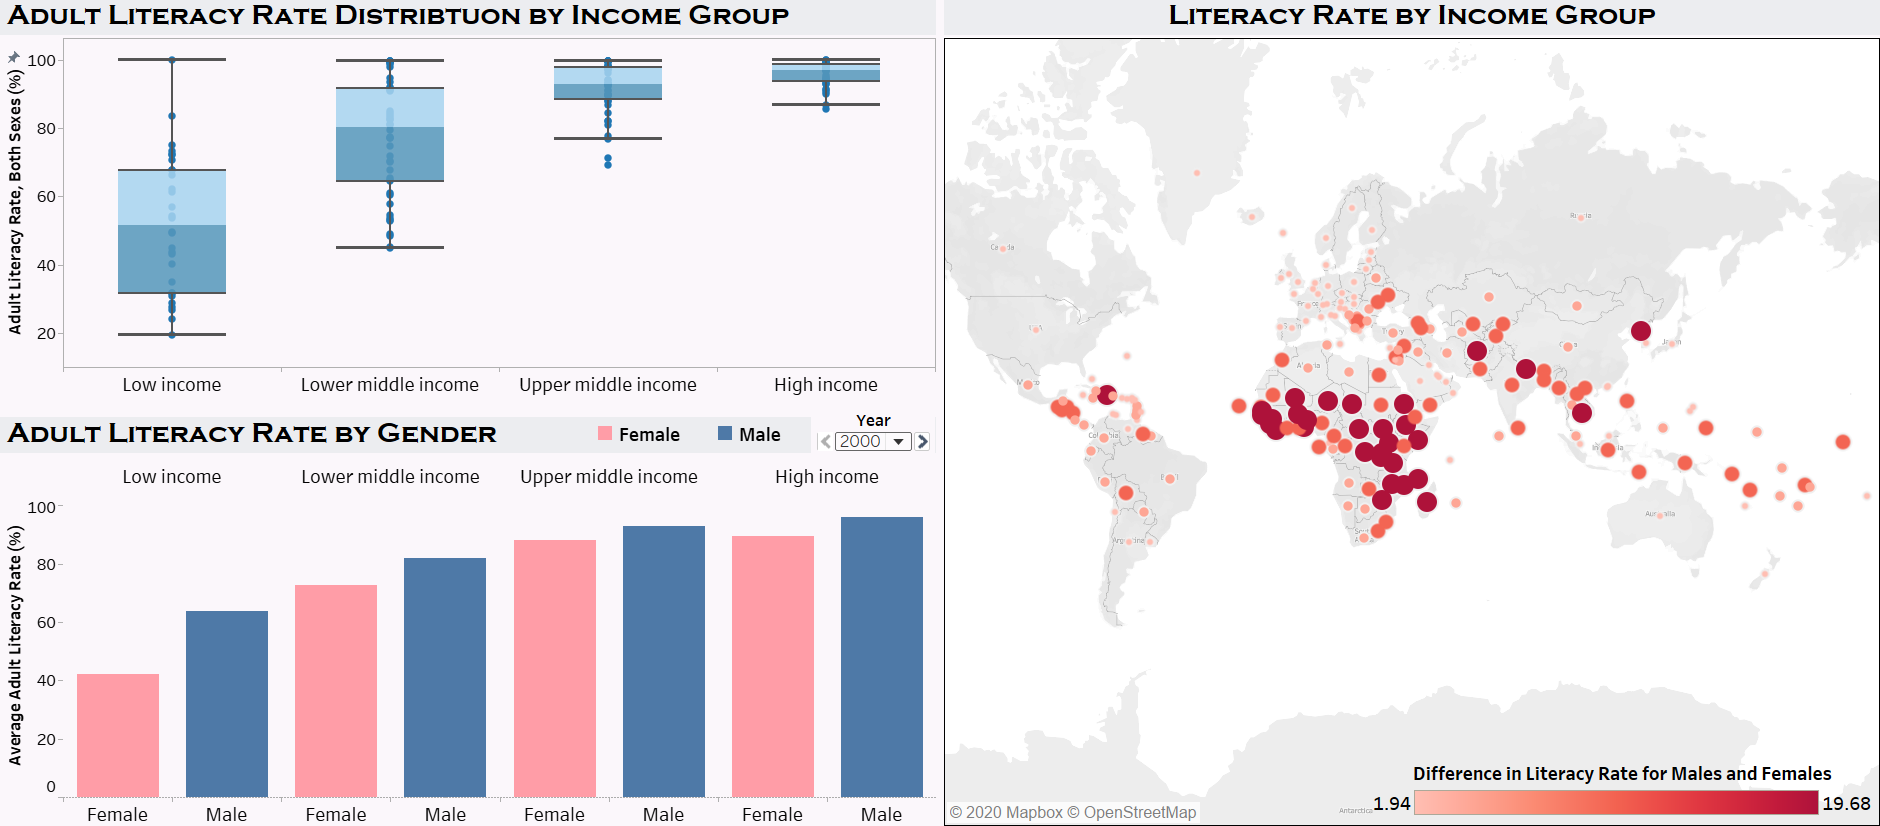

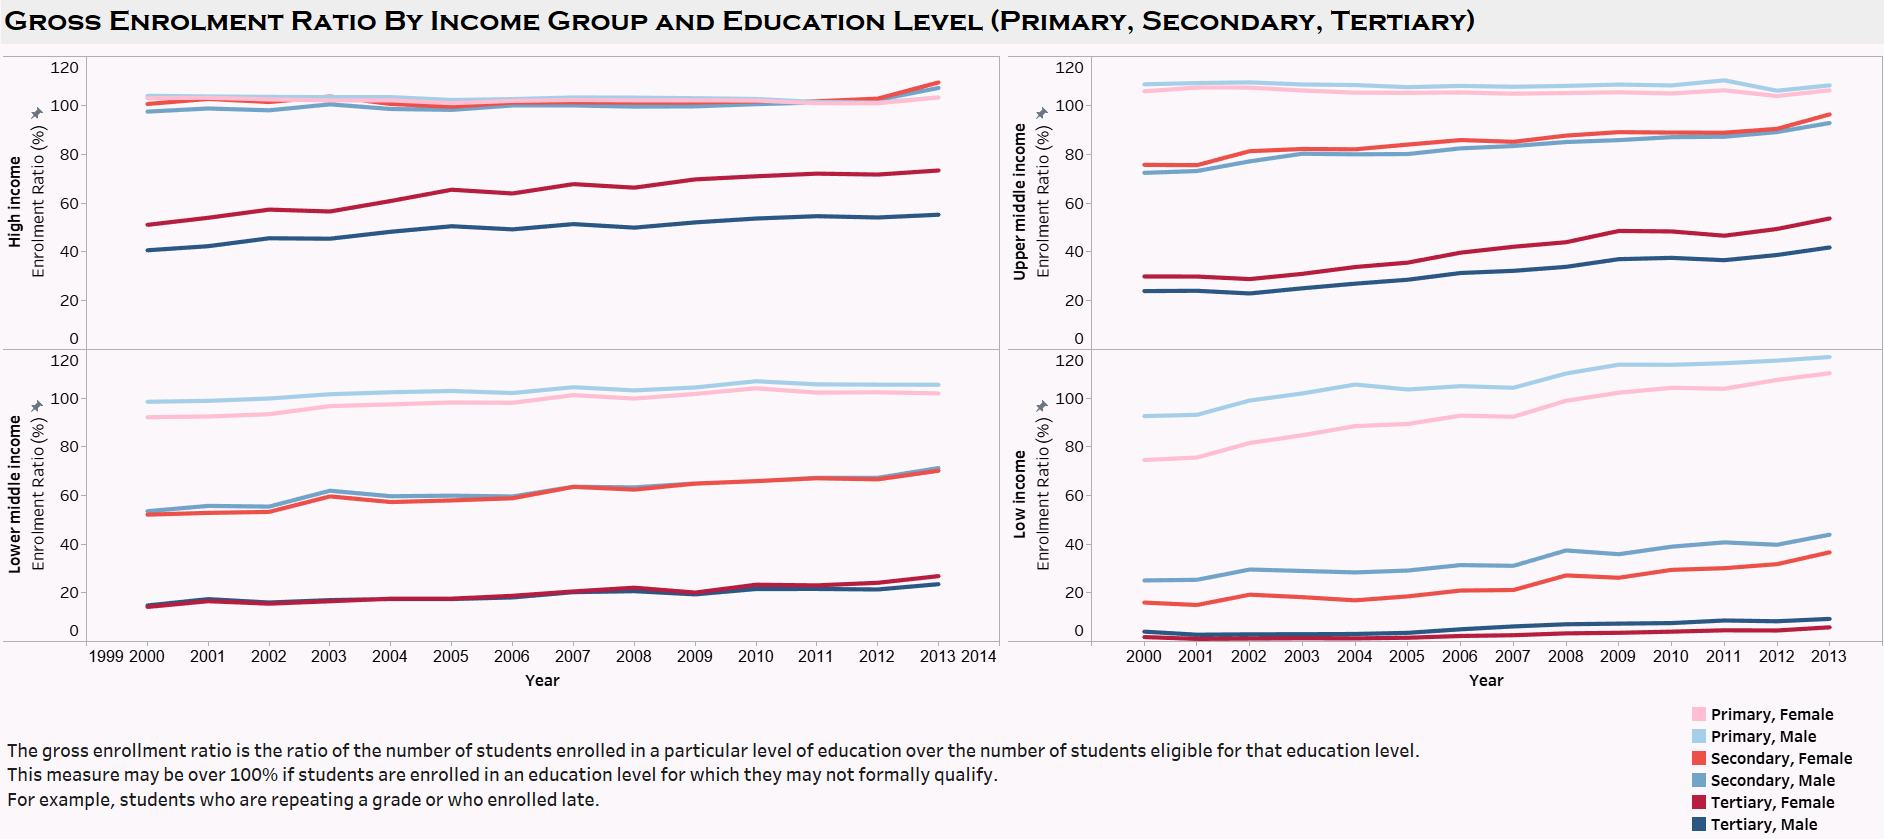

## Analytical Report on Employment

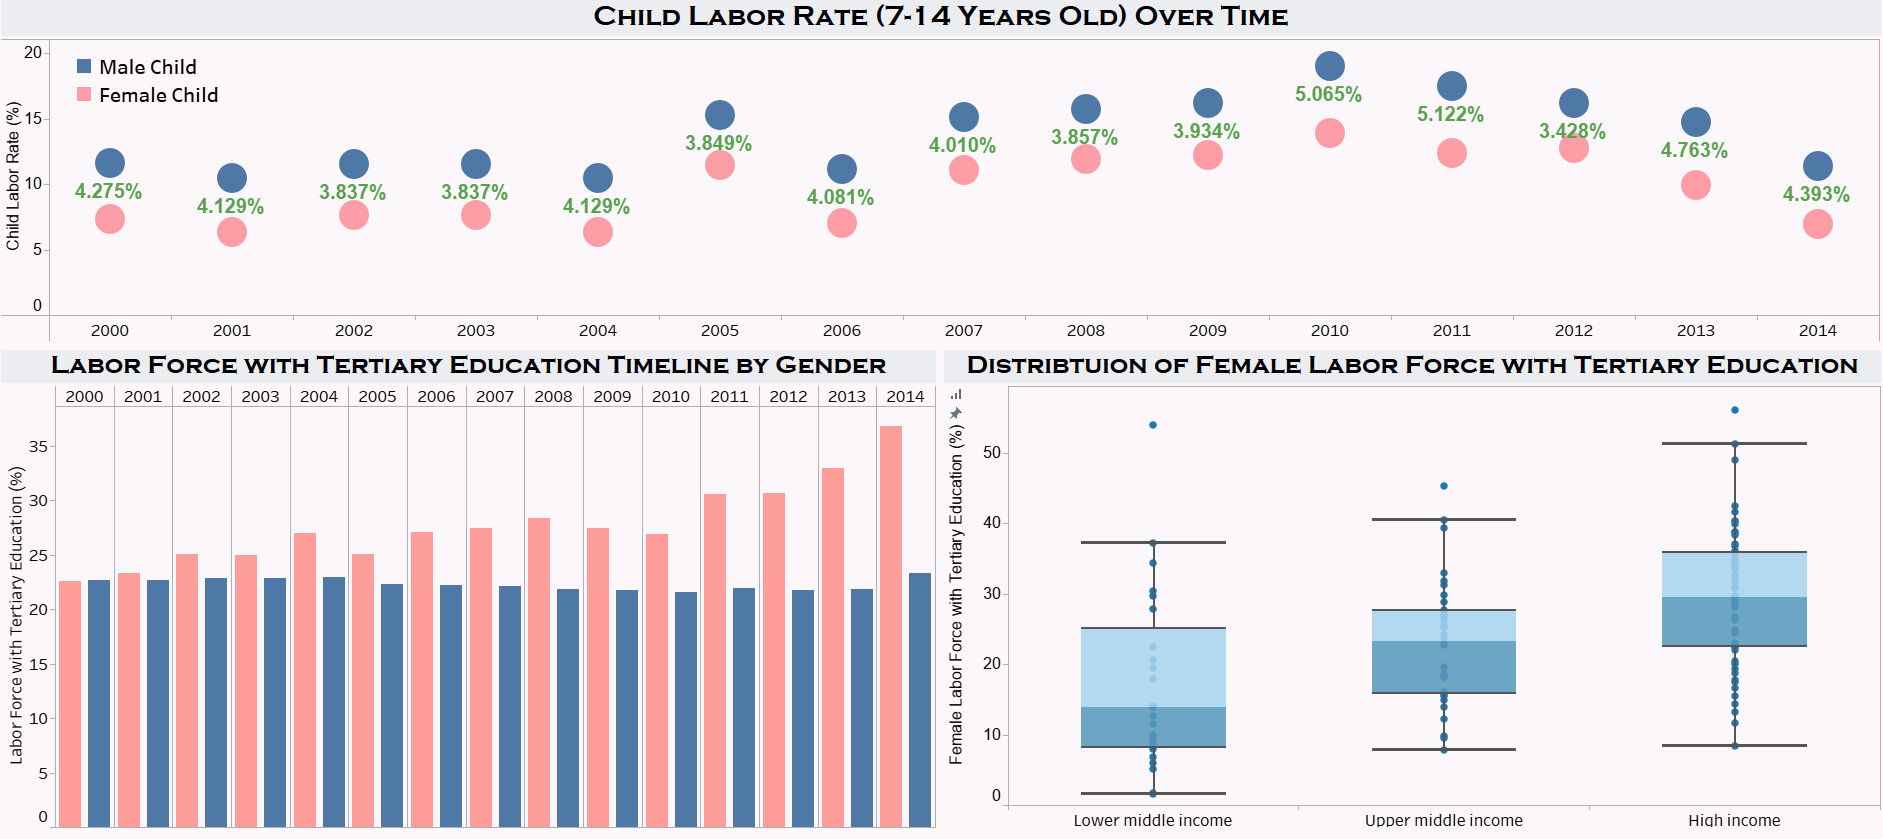

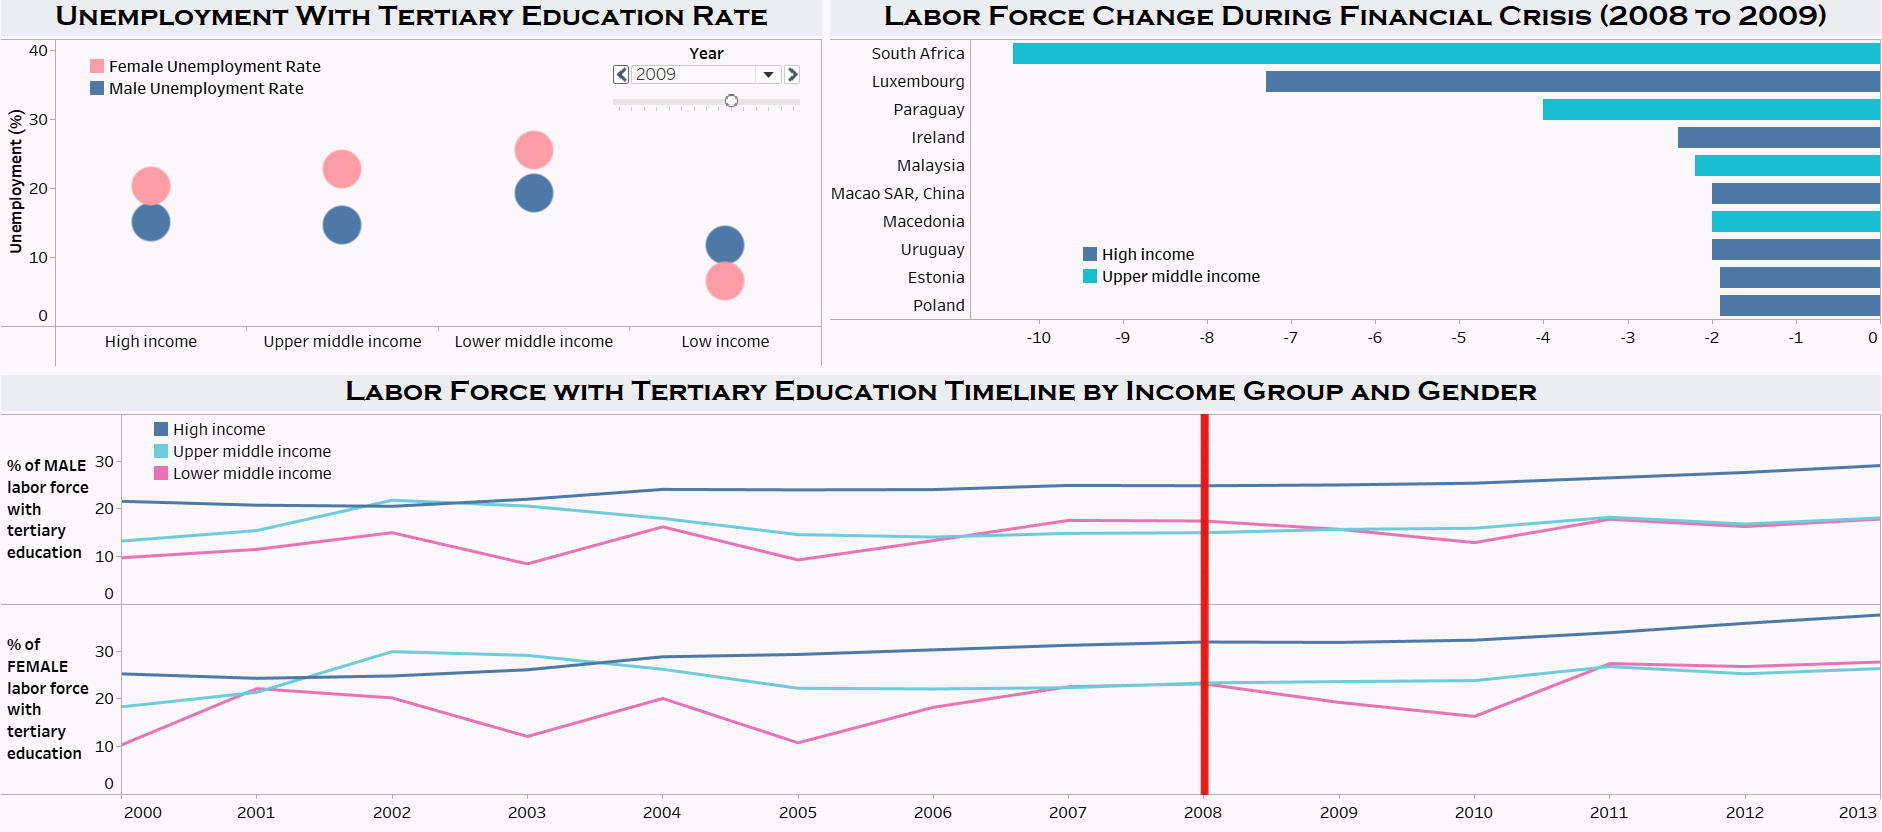

## Relationship between Education and Employment

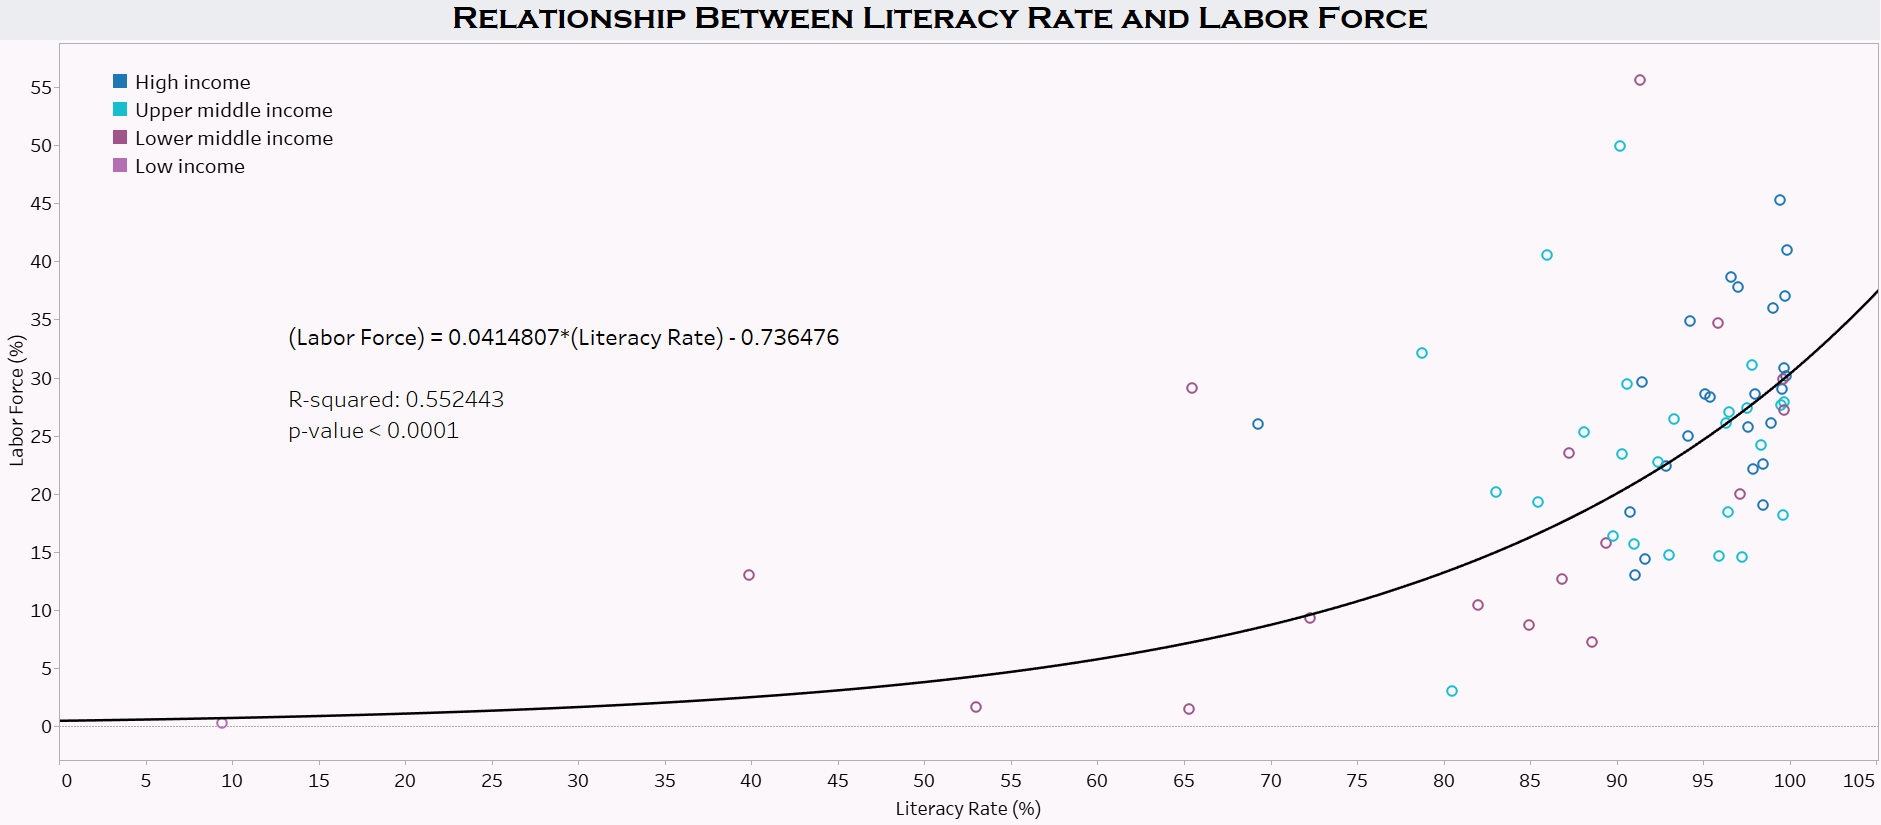

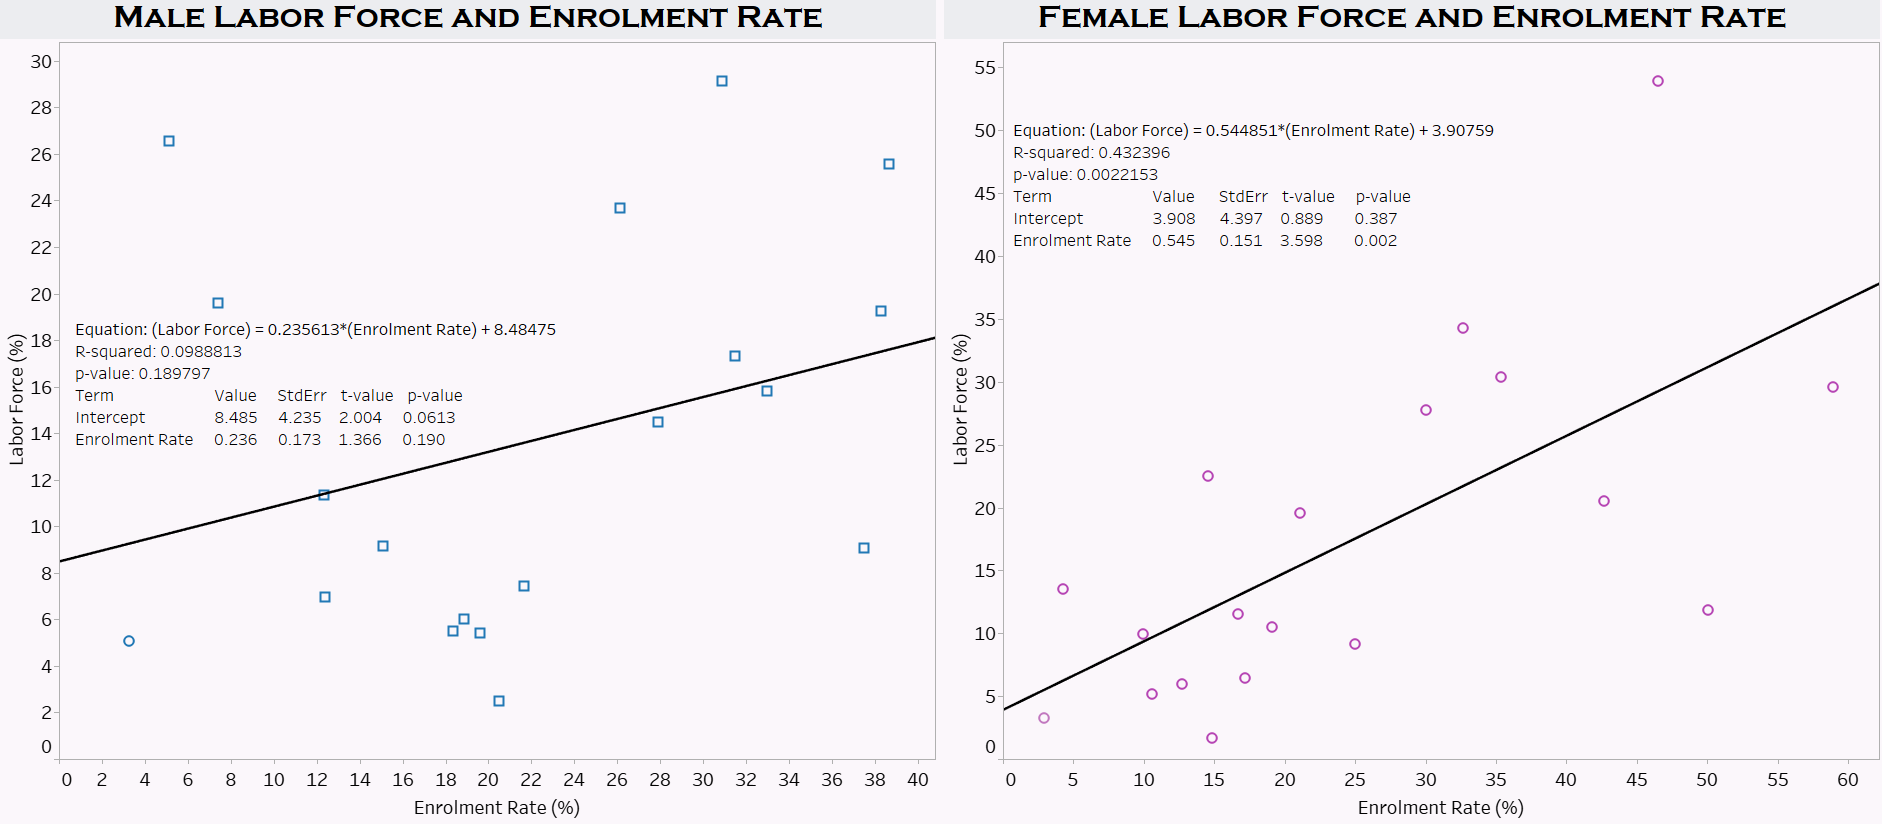

# Conclusion

---





*   There is higher variation in indicators for low income countries and the distribution of literacy rates is wider for low income groups.
*   Gender inequality is more prevalent in low income countries.
*   Child labor is higher among males which implies that there are higher expectations for males to enter the workforce than females, even at a young age.
*    Labor force for high income and upper middle income countries were most affected during the 2008 financial crisis.

## Challenges Faced

*   **Data format**
> The indicators were stacked in one column, making it difficult to use them without writing custom SQL queries.
* **Feature selection**
> There are a vast number of indicators in the dataset which made feature selection more difficult for our linear regression model.
> For example, predicting male labor force using enrolment rate did not generate a strong model.

## Future Work
*   Gathering additional region-specific data and observations for the low-income group.
  
*   Feature engineering -- Identify the best model to select most important features for predicting male and female labor force.         
  
* Predictive analysis

1.   Use a classification model to predict income groups for countries for future years. 
2.   Create pivoted data frames for specific use cases.


## Resouces

*    https://databank.worldbank.org/metadataglossary/world-development-indicators/series/SE.ADT.LITR.ZS#:~:text=Literacy%20rate%20is%20an%20outcome,skills%20for%20men%20and%20women

*   https://ourworldindata.org/literacy

*  https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups

*   https://www.tandfonline.com/doi/abs/10.1080/09765239.2014.11884980#:~:text=The%20global%20financial%20crisis%20has,to%20remain%20high%20with%2025%25